<a href="https://colab.research.google.com/github/LEESOOJAE1978/sjcu/blob/main/exe12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
#본 코드는 텐서플로우 2.0 프로그래밍, 김환희, 위키북스 p203~216을 활용했습니다
import tensorflow as tf
import keras
import numpy as np

리뷰데이터 불러오기

In [44]:
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

데이터 로드 및 확인

In [45]:
#데이터를 메모리에 불러오고 인코딩 형식으로 utf-8을 지정
train_txt = open(path_to_train_file, 'rb').read().decode(encoding = 'utf-8')
test_txt = open(path_to_test_file, 'rb').read().decode(encoding = 'utf-8')

#텍스트가 총 몇 자인지 확인
print('Length of train text: {} characters'.format(len(train_txt)))
print('Length of test text: {} characters'.format(len(test_txt)))
print()

#처음 300자 확인
print(train_txt[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


학습을 위한 정답 데이터(Y)만들기

In [46]:
train_Y = np.array([[int(row.split('\t')[2])] for row in train_txt.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_txt.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


문자 데이터 전처리 함수

In [47]:
import re #https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py

def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()


In [48]:
train_text_X = [row.split('\t')[1] for row in train_txt.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

#문장을 띄어쓰기 단어로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
  print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


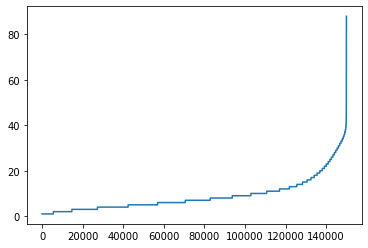

150000


In [50]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(1<=25) for l in sentence_len]))

최대 단어 5음절 길이로 정제

In [51]:
sentences_new = [ ]
for sentence in sentences:
  sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new
for i in range(5):
  print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


패딩 작업을 통해 문장의 길이 25개 단어로 동일하게 하고 출현 빈도가 가장 높은 단어만 사용하기 위해 Tokenizer 사용

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000) #데이터에 출현하는 모든 단어의 개수를 세고 빈도수로 정렬해서 num_words에 지정된 만큼만 숫자로 반환, 나머지는 0으로 반환
tokenizer.fit_on_texts(sentences) #Tokenizer에 데이터를 실제로 입력
train_X = tokenizer.texts_to_sequences(sentences) #문장을 입력받아 숫자로 반환
train_X = pad_sequences(train_X, padding = 'post') #패딩 추가, padding 파라미터는 pre와 post, pre는 문장 앞에, post는 문장 뒤에 패딩 더함

print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [54]:
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])
temp = tokenizer.texts_to_sequences(['#$#$#','경우는', '잊혀질', '연기가'])
print(temp)
temp = pad_sequences(temp, padding = 'post')

경우는
잊혀질
[[], [19999], [], [106]]


모델생성

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


학습

In [56]:
history = model.fit(train_X, train_Y, epochs=5, batch_size = 128, validation_split = 0.2)

Epoch 1/5
938/938 [==============================] - 133s 140ms/step - loss: 0.4367 - accuracy: 0.7818 - val_loss: 0.3824 - val_accuracy: 0.8238
Epoch 2/5
938/938 [==============================] - 130s 138ms/step - loss: 0.3242 - accuracy: 0.8473 - val_loss: 0.3839 - val_accuracy: 0.8215
Epoch 3/5
938/938 [==============================] - 127s 135ms/step - loss: 0.2722 - accuracy: 0.8691 - val_loss: 0.4252 - val_accuracy: 0.8151
Epoch 4/5
938/938 [==============================] - 125s 133ms/step - loss: 0.2276 - accuracy: 0.8892 - val_loss: 0.4521 - val_accuracy: 0.8151
Epoch 5/5
938/938 [==============================] - 124s 132ms/step - loss: 0.1940 - accuracy: 0.9046 - val_loss: 0.5426 - val_accuracy: 0.8061


학습결과 확인


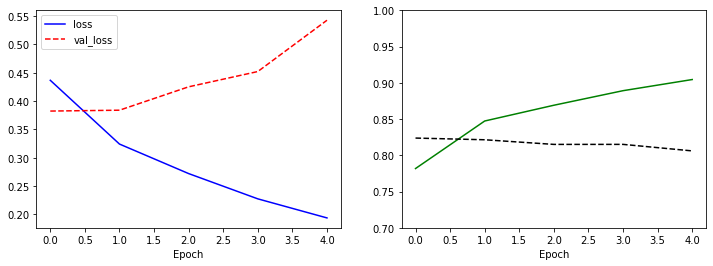

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.show()

모델 테스트

In [58]:
test_text_X = [row.split('\t')[1] for row in test_txt.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]
sentences_new = []
for sentence in sentences:
  sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new
test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding = 'post')

model.evaluate(test_X, test_Y, verbose = 0)

[0.55741947889328, 0.7976800203323364]

테스트 결과 확인

In [62]:
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다'
test_sentence = test_sentence.split(' ')
test_sentences = [ ]
now_sentence = [ ]
for word in test_sentence:
  now_sentence.append(word)
  test_sentences.append(now_sentence[:])

test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding = 'post', maxlen = 25)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
  print(sentence)
  print(prediction[idx])

['재미있을']
[0.45964074 0.54035926]
['재미있을', '줄']
[0.32515445 0.6748455 ]
['재미있을', '줄', '알았는데']
[0.31226414 0.68773586]
['재미있을', '줄', '알았는데', '완전']
[0.33377665 0.66622335]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.33377665 0.66622335]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.41921413 0.5807858 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.9847692  0.01523074]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.99765235 0.00234767]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다']
[0.9981377  0.00186227]


In [ ]:
_